### Load Packages

In [71]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import sys, subprocess
from PIL import Image
import pickle
from armcodlib import *


In [72]:
print(tf.__version__)

2.0.0-dev20190519


### Create arm positions dataset

In [73]:
NB_POSTURE = 6
NB_COMMAND = 1000
NB_DATA = NB_POSTURE*NB_COMMAND
BATCH_SIZE = 100
TEST_BUF = 1000
IMG_SIZE = 64
DIMS = (IMG_SIZE, IMG_SIZE,2)
N_TRAIN_BATCHES =int(NB_DATA/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)



In [74]:
train_posture_before, train_posture_after, train_command = create_random_data(NB_POSTURE, NB_COMMAND, "train")
train_images = load_and_process_images(NB_DATA, "train")
train_posture_before, train_posture_after, test_command = create_random_data(10,10, "test")
test_images = load_and_process_images(100, "test")

In [75]:
train_images_pickle = open("pickles/train_images.pickle", "wb")
test_images_pickle = open("pickles/test_images.pickle", "wb")
train_command_pickle = open("pickles/train_command.pickle", "wb")
test_command_pickle = open("pickles/test_command.pickle", "wb")

pickle.dump(train_images, train_images_pickle)
pickle.dump(test_images, test_images_pickle)
pickle.dump(train_command, train_command_pickle)
pickle.dump(test_command, test_command_pickle)

train_images_pickle.close()
test_images_pickle.close()
test_command_pickle.close()
train_command_pickle.close()

In [7]:
print('shape train_images ', shape(train_images))
print('shape test_images', shape(test_images))


('shape train_images ', TensorShape([6000, 64, 64, 2]))
('shape test_images', TensorShape([100, 64, 64, 2]))


In [8]:
train_images = np.expand_dims(train_images, axis=1)
test_images = np.expand_dims(test_images, axis=1)

In [9]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images,train_images[:,:,:,:,1:]))
    .shuffle(NB_DATA)
    #.batch(BATCH_SIZE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_images, test_images[:,:,:,1:]))
    .shuffle(TEST_BUF)
    #.batch(BATCH_SIZE)
)

### Define the network architecture

In [76]:
encoder = build_dense_encoder()
decoder = build_dense_decoder()

### Create Model

In [77]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder = tf.keras.Model(encoder.input, decoder(encoder(encoder.input)), name = "autoencoder")

autoencoder.compile(optimizer = optimizer, 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

### Train model

In [97]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder.fit(train_dataset, 
                    epochs = 10,
                    callbacks=[tensorboard_callback])

Epoch 1/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0048 - accuracy: 0.9899 - kullback_leibler_divergence: 0.0719
Epoch 2/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0048 - accuracy: 0.9899 - kullback_leibler_divergence: 0.0721
Epoch 3/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0048 - accuracy: 0.9899 - kullback_leibler_divergence: 0.0720
Epoch 4/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0048 - accuracy: 0.9899 - kullback_leibler_divergence: 0.0719
Epoch 5/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0048 - accuracy: 0.9899 - kullback_leibler_divergence: 0.0721
Epoch 6/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.0048 - accuracy: 0.9899 - kullback_leibler_divergence: 0.0723
Epoch 7/10
6000/6000 [==============================] - 31s 5ms/step - loss: 0.0048 - accuracy: 0.9899 - kullback_leibler_divergence: 0.0723
Epoch 8/10
60

In [111]:
example_data = next(iter(train_dataset))

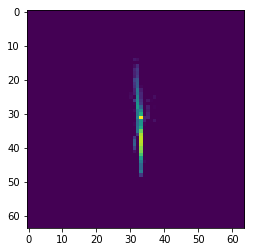

In [134]:
imshow(autoencoder.predict(example_data)[0,:,:,0])

In [114]:
imshow(example_data[0][0,:,:,1])

TypeError: 'IteratorV2' object does not support indexing

### Alternative convolutional model

In [39]:
encoder_conv = build_conv2D_encoder()
decoder_conv = build_dense_decoder()


In [121]:
optimizer = tf.keras.optimizers.Adam(1e-3)

autoencoder_conv = tf.keras.Model(encoder_conv.input, decoder_conv(encoder_conv(encoder_conv.input)), name = "autoencoder")

autoencoder_conv.compile(optimizer = 'adam', 
             loss='mse',
             metrics=['accuracy','kullback_leibler_divergence'])

In [122]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = autoencoder_conv.fit(train_dataset, 
                    epochs = 5,
                    callbacks=[tensorboard_callback])

Epoch 1/5
6000/6000 [==============================] - 52s 9ms/step - loss: 0.0043 - accuracy: 0.9902 - kullback_leibler_divergence: 0.0655
Epoch 2/5
6000/6000 [==============================] - 51s 8ms/step - loss: 0.0043 - accuracy: 0.9902 - kullback_leibler_divergence: 0.0653
Epoch 3/5
6000/6000 [==============================] - 51s 9ms/step - loss: 0.0043 - accuracy: 0.9902 - kullback_leibler_divergence: 0.0652
Epoch 4/5
6000/6000 [==============================] - 51s 9ms/step - loss: 0.0043 - accuracy: 0.9903 - kullback_leibler_divergence: 0.0650
Epoch 5/5
6000/6000 [==============================] - 51s 9ms/step - loss: 0.0043 - accuracy: 0.9902 - kullback_leibler_divergence: 0.0649


In [131]:
example_data = next(iter(train_dataset))


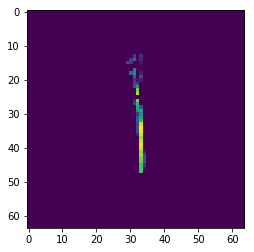

In [132]:
imshow(autoencoder_conv.predict(example_data)[0,:,:,0])

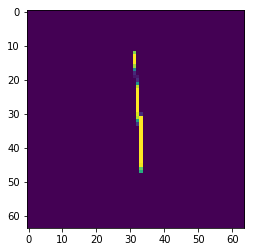

In [133]:
imshow(example_data[1][0,:,:,0])

In [137]:
model = encoder_conv  # create the original model

layer_name = 'conv_x_1'
intermediate_layer_model = tf.keras.Model(inputs=autoencoder_conv.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(example_data)



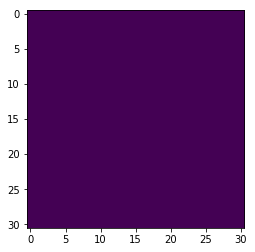

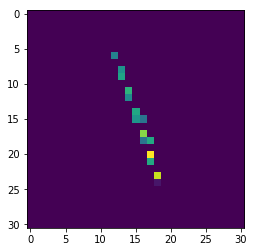

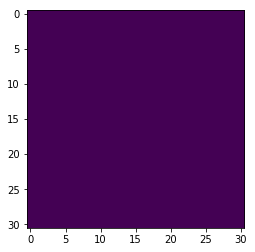

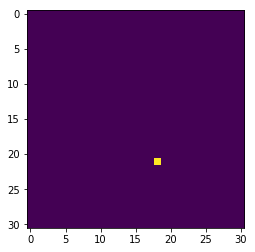

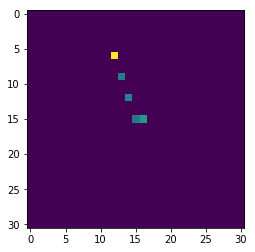

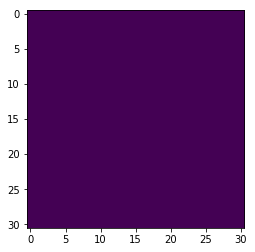

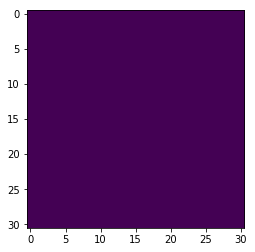

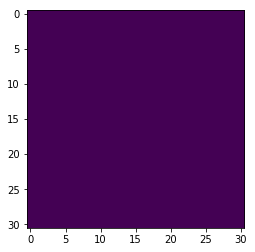

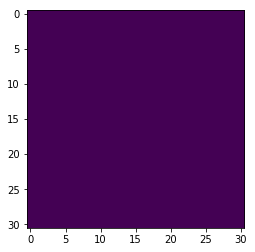

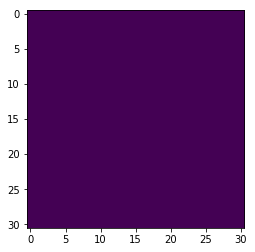

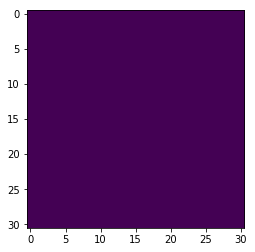

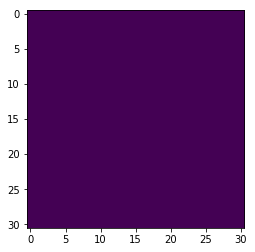

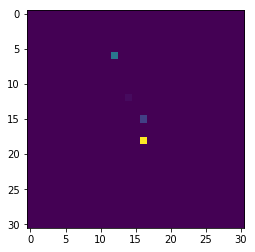

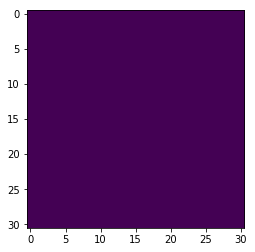

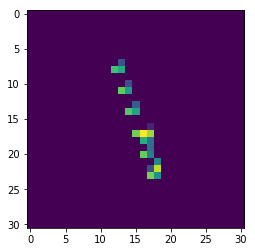

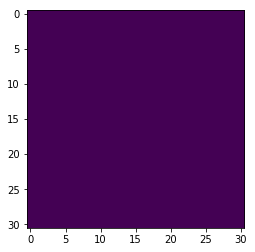

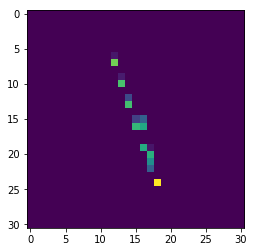

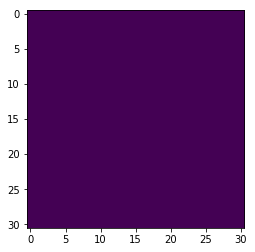

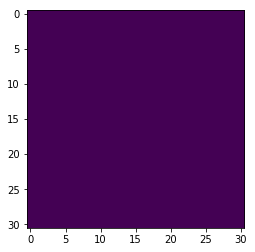

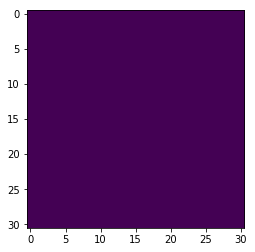

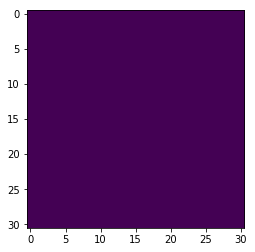

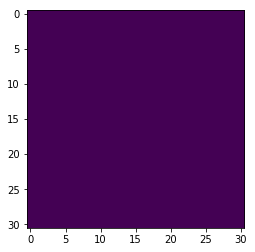

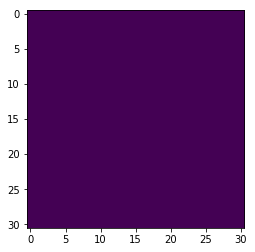

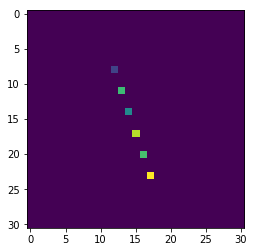

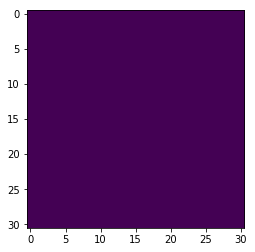

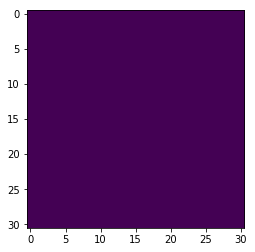

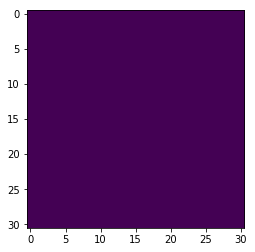

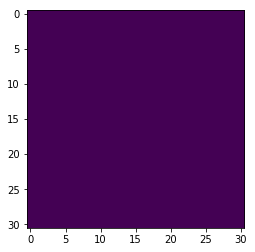

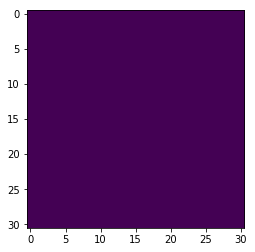

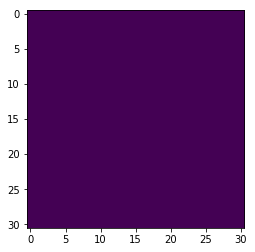

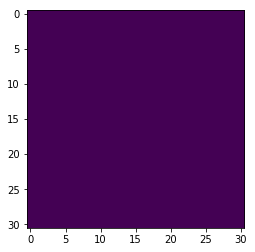

In [138]:

for i in range(31):
    plt.figure()
    plt.imshow(intermediate_output[0][:,:,i])

In [174]:
from keras import backend as K

with tf.GradientTape() as g :
    def generate_pattern(layer_name, filter_index, size=150):
        layer_output = encoder_conv.get_layer(layer_name).output
        loss = tf.keras.backend.mean(layer_output[:,:,:,filter_index])
        g.watch(loss)
        grads = g.gradient(loss, encoder_conv.input)
        grads /= (tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(grads)))+1e-5)
        iterate = K.function([encoder_conv.input], [loss, grads])
        input_img_data = np.random.random((1,img_size, img_size,3))*20 + 128.
        step = 1.
        for i in range(40):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
        img = input_img_data[0]
        return deprocess_images(img)

    def deprocess_image(x):
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x+= 0.5
        x = np.clip(x,0,255).astype('uint8')
        return x
    plt.imshow(generate_pattern('conv_x_1', 0))

ValueError: Attempt to convert a value (None) with an unsupported type (<type 'NoneType'>) to a Tensor.

In [165]:
encoder_conv.input

<tf.Tensor 'encoder_input_3:0' shape=(None, 64, 64, 2) dtype=float32>

In [168]:
layer_output = encoder_conv.get_layer(layer_name).output
       
loss = tf.keras.backend.mean(layer_output[:,:,:,0])
        

In [169]:
loss

<tf.Tensor 'Mean_9:0' shape=() dtype=float32>

In [175]:
with tf.GradientTape() as g:
    g.watch(loss)
    grads = g.gradient(loss, encoder_conv.input)
        

In [176]:
print grads

None
